# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle. EDA & ML

## Описание кейса и постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Загрузка данных

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

**Описание полей**

* *hotel_address* — адрес отеля;
* *review_date* — дата, когда рецензент разместил соответствующий отзыв;
* *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* *hotel_name* — название отеля;
* *reviewer_nationality* — страна рецензента;
* *negative_review* — отрицательный отзыв, который рецензент дал отелю;
* *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
* *positive_review* — положительный отзыв, который рецензент дал отелю;
* *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
* ***reviewer_score*** — оценка, которую рецензент поставил отелю на основе своего опыта. Целевой признак, который нужно предсказать;
* *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
* *total_number_of_reviews* — общее количество действительных отзывов об отеле;
* *tags* — теги, которые рецензент дал отелю;
* *days_since_review* — количество дней между датой проверки и датой очистки;
* *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* *lat* — географическая широта отеля;
* *lng* — географическая долгота отеля.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# **Обработка признаков**

**1. Признак hotel_address**

In [13]:
data['hotel_address'].head()

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
Name: hotel_address, dtype: object

Для каждой строки данного признака характерна единая структура: в самом конце адресной строки указана страна, в котором расположен отель, перед этим указан город. Воспользуемся этим и добавит в датасет новые признаки со страной и городом:

In [14]:
#Выделим страну и город, в котором расположен отель
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if x.split(' ')[-1]!='Kingdom' else 'United Kingdom')
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-1]!='Kingdom' else 'London')
display(data.groupby(['country', 'city'])['hotel_address'].count())

country         city     
Austria         Vienna        38939
France          Paris         59928
Italy           Milan         37207
Netherlands     Amsterdam     57214
Spain           Barcelona     60149
United Kingdom  London       262301
Name: hotel_address, dtype: int64

Как видно из сгруппированных данных, между городом и страной существует взаимно однозначное соответствие, значит, один из признаков можно удалить. Удалим признак страны, а город закодируем:

In [15]:
data = pd.get_dummies(data, columns=['city']) #получаем новые дамми-признаки
data = data.drop(['country', 'hotel_address'], axis = 1) #удаляем страну
data.shape

(515738, 23)

**2. Признак review_date** 

Приведем признак review_date к формату даты и времени и выделим из него месяц и время года. Год выделять не будем, так как этот признак ухудшил метрику:

In [16]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_month'] = data['review_date'].dt.month #выделяем месяц
#data['review_year'] = data['review_date'].dt.year #выделяем год
#data['review_day_of_wk'] = data['review_date'].dt.dayofweek

data.drop('review_date', axis = 1, inplace=True)

#data['is_weekend'] = data['review_day_of_wk'].apply(lambda x: 1 if x>4 else 0)
data['is_spring'] = data['review_month'].apply(lambda x: 1 if x in [3,4,5] else 0)
data['is_summer'] = data['review_month'].apply(lambda x: 1 if x in [6,7,8] else 0)
data['is_autumn'] = data['review_month'].apply(lambda x: 1 if x in [9,10,11] else 0)

In [17]:
data.shape

(515738, 26)

**3. Признак hotel_name**

In [18]:
data['hotel_name'].nunique(dropna=False)

1492

Данный признак имеет 1492 уникальных значений, то есть данные сгруппированы в разрезе названия отеля. Поэтому закодируем этот признак, а само название отеля удалим:

In [19]:
data['hotel_name'] = data['hotel_name'].astype('category')
data['hotel_name_code'] = data['hotel_name'].cat.codes

data[['hotel_name', 'hotel_name_code']]

,hotel_name,hotel_name_code
0,Hotel Da Vinci,612
1,Urban Lodge Hotel,1445
2,Alexandra Barcelona A DoubleTree by Hilton,33
3,Hotel Principe Di Savoia,735
4,Hotel Esther a,633
...,...,...
515733,Hotel Moonlight,711
515734,BEST WESTERN PLUS Amedia Wien,104
515735,Bloomsbury Palace Hotel,177
515736,The Marble Arch London,1364


In [20]:
#Удалим признак
data.drop('hotel_name', axis = 1, inplace=True)

**4. Признак широта и долгота отеля**

В датасете пропущены значения широты и долготы отеля, заполним их нулями:

In [21]:
display(data[['lat', 'lng']].isnull().sum())
#data_cleaned = data.dropna(axis=0)
#data_grouped = data_cleaned.groupby(by='city',as_index=False)['lat','lng'].mean()

#data_grouped

lat    3268
lng    3268
dtype: int64

In [22]:

data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

**5. Обработка тегов:**

Преобразуем теги в список и далее создадим новые признаки для 15 самых частых тегов:

In [23]:
d = ['[', ']', '"', "'"]
def tag_list_making(arg):
    '''Функция преобразует теги в список'''
    for symbol in arg: 
        if symbol in d:
            arg = arg.replace(symbol, '')     
    arg = arg.split(', ')
    return arg 
data['tags'] = data['tags'].apply(tag_list_making)

In [24]:
top_tags = [' Leisure trip ',
 ' Submitted from a mobile device ',
 ' Couple ',
 ' Stayed 1 night ',
 ' Stayed 2 nights ',
 ' Solo traveler ',
 ' Stayed 3 nights ',
 ' Business trip ',
 ' Group ',
 ' Family with young children ',
' Stayed 4 nights ',
 ' Double Room ',
 ' Standard Double Room ',
 ' Superior Double Room ',
 ' Family with older children ']

for tag in top_tags:
    tag_name = str(tag)
    data[tag_name] =  data['tags'].apply(lambda x: 1 if tag_name in x else 0)

data.drop('tags', axis = 1, inplace=True)

**6. Признак days_since_review**

Сейчас данный признак имеет тип object. Выделим из него количество дней с момента написания отзыва и преобразуем его в числовой формат:

In [25]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])
data['days_since_review'] = data['days_since_review'].astype('int')

**7. Признаки 'negative_review' и 'positive_review'**

Сейчас данный признак имеет всего 11 уникальных строковых значений. Напишем функцию, которая определяет, есть ли негатив в отзыве:

In [26]:
data['negative_review'].value_counts().iloc[:11]

No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
 None             984
                  849
 N a              509
 Breakfast        407
 Small room       373
 Location         368
Name: negative_review, dtype: int64

In [27]:
def has_negative_review(arg):
    
    '''Функция определяет, есть ли в отзыве негатив'''
    
    if arg.lower().strip() in ['no negative', 'nothing']:
        return 0
    else:
        return 1
    
    
data['has_negative'] = data['negative_review'].apply(has_negative_review)# применим функцию к столбцу
data['has_negative'].value_counts()# посмотрим, что получилось

1    366663
0    149075
Name: has_negative, dtype: int64

Аналогичные манипуляции проделаем с признаком 'positive_review'

In [28]:
data['positive_review'].value_counts()

No Positive                                                                                                                                                35946
 Location                                                                                                                                                   9222
 Everything                                                                                                                                                 2284
 location                                                                                                                                                   1677
 Nothing                                                                                                                                                    1243
                                                                                                                                                           ...  
 Lots places to eat near Also near

In [29]:
def has_positive_review(arg):
    
    '''Функция определяет, есть ли в отзыве позитив'''
    
    if arg.lower().strip() in ['no positive', 'nothing']:
        return 0
    else:
        return 1
    
    
data['has_positive'] = data['positive_review'].apply(has_positive_review)
data['has_positive'].value_counts()

1    478061
0     37677
Name: has_positive, dtype: int64

Удалим признаки 'negative_review' и 'positive_review':

In [30]:
data.drop(['negative_review','positive_review'], axis = 1, inplace=True)

**8. Признак reviewer_nationality**

Из данного признака извлечем самые частые национальности респондентов и выделим их в отдельные признаки. Национальности респондентов, которые оставили менее 7000 отзвывов объединим в 'other':

In [31]:
df_vc = pd.DataFrame(data['reviewer_nationality'].value_counts())
df_vc = df_vc.drop(df_vc[df_vc['reviewer_nationality']<7000].index)
df_vc.head()

,reviewer_nationality
United Kingdom,245246
United States of America,35437
Australia,21686
Ireland,14827
United Arab Emirates,10235


In [32]:
for nat in df_vc.index:
    data['reviewer_nationality_'+nat] = data['reviewer_nationality'].apply(lambda x: 1 if x == nat else 0)
data['reviewer_nationality_other'] = data['reviewer_nationality'].apply(lambda x: 1 if x not in df_vc.index else 0)
data.drop('reviewer_nationality', axis = 1, inplace=True)

In [33]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,reviewer_nationality_ Australia,reviewer_nationality_ Ireland,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ Saudi Arabia,reviewer_nationality_ Netherlands,reviewer_nationality_ Switzerland,reviewer_nationality_ Germany,reviewer_nationality_ Canada,reviewer_nationality_ France,reviewer_nationality_other
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.129144,2.805910,0.749999,...,0.042048,0.028749,0.019845,0.017356,0.017009,0.016826,0.015397,0.015306,0.014147,0.269080
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,5.227925,4.570389,0.433014,...,0.200700,0.167101,0.139469,0.130593,0.129303,0.128621,0.123127,0.122768,0.118096,0.443482
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,-0.369758,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.212857,-0.143372,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.831098,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Получившиеся признаки:

In [34]:
data.nunique(dropna=False)

additional_number_of_scoring                        480
average_score                                        34
review_total_negative_word_counts                   402
total_number_of_reviews                            1142
review_total_positive_word_counts                   365
total_number_of_reviews_reviewer_has_given          198
days_since_review                                   731
lat                                                1473
lng                                                1473
sample                                                2
reviewer_score                                       38
city_Amsterdam                                        2
city_Barcelona                                        2
city_London                                           2
city_Milan                                            2
city_Paris                                            2
city_Vienna                                           2
review_month                                    

## Корреляция и нормализация признаков

**1. Корреляция**

Выведем признаки, которые имеют коррелцию выше 0.85 и удалим один из них:

In [35]:
pivot = data.corr()
pivot = pivot.drop(['sample', 'reviewer_score'], axis=0)
pivot = pivot.drop(['sample', 'reviewer_score'], axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.85 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

fig = px.imshow(pivot)
fig.show()

In [36]:
data = data.drop([' Business trip '], axis=1)

**2. Нормализация и стандартизация**
*Нормализация и стандартизация не привели к улучшению метрики, поэтому оставим данные как есть*

In [37]:
# Посмотрим, остались ли у нас необработанные признаки
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns

[]

In [38]:
data.drop(object_columns, axis = 1, inplace=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   review_total_negative_word_counts                515738 non-null  int64  
 3   total_number_of_reviews                          515738 non-null  int64  
 4   review_total_positive_word_counts                515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given       515738 non-null  int64  
 6   days_since_review                                515738 non-null  int64  
 7   lat                                              515738 non-null  float64
 8   lng                                              515738 non-null  float64
 9   sample         

## Обучение модели

In [40]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [41]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 49), (386803, 49), (386803, 48), (309442, 48), (77361, 48))

In [43]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [44]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [46]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

print('MAPE:', MAPE(y_test, y_pred))

MAPE: 0.9268132906577138
MAPE: 13.347732900662217


<AxesSubplot:>

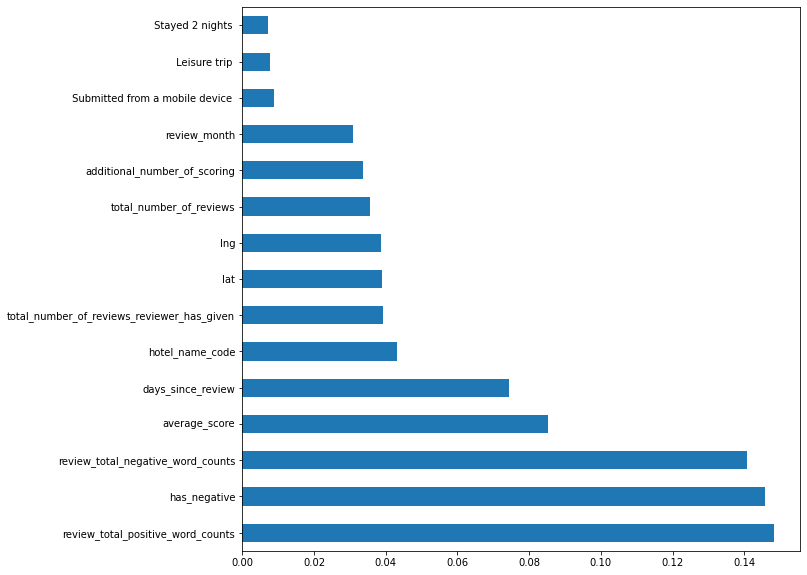

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [48]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,reviewer_nationality_ Australia,reviewer_nationality_ Ireland,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ Saudi Arabia,reviewer_nationality_ Netherlands,reviewer_nationality_ Switzerland,reviewer_nationality_ Germany,reviewer_nationality_ Canada,reviewer_nationality_ France,reviewer_nationality_other
79197,161,8.2,17,684,21,2,1,51.496301,-0.179685,0.0,...,0,0,0,0,0,0,0,0,0,1
107447,2288,8.1,0,9568,2,1,681,51.511099,-0.120867,0.0,...,0,0,0,0,0,0,0,0,0,0
9110,198,8.2,8,1046,23,2,102,51.494265,-0.136603,0.0,...,0,0,0,0,0,0,0,0,0,0
83829,61,7.4,68,334,3,5,641,51.518277,-0.158351,0.0,...,0,0,0,0,0,0,0,0,0,0
46980,419,8.4,78,4527,10,2,29,41.375029,2.149117,0.0,...,0,0,0,0,0,0,0,0,0,0
41652,803,8.4,13,3911,0,5,142,52.376752,4.904618,0.0,...,1,0,0,0,0,0,0,0,0,0
37064,1258,9.4,36,4204,23,3,424,51.502435,-0.000250,0.0,...,0,0,0,0,0,0,0,0,0,0
12888,612,8.6,2,5018,4,4,244,52.385649,4.834443,0.0,...,0,0,0,0,0,0,0,0,0,1
85253,1936,8.7,17,7491,8,1,109,51.510841,-0.078058,0.0,...,0,0,0,0,0,0,0,0,0,0
76622,101,8.1,6,1991,3,9,681,41.433756,2.147327,0.0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [50]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [51]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [52]:
predict_submission

array([8.782, 6.892, 8.272, ..., 7.983, 9.535, 7.465])

In [53]:
list(sample_submission)

['reviewer_score', 'id']

In [54]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.782,488440
1,6.892,274649
2,8.272,374688
3,9.605,404352
4,9.451,451596
5,8.630,302161
6,7.912,317079
7,7.210,13963
8,8.599,159785
9,7.856,195089
